In [1]:
"""
From https://physionet.org/content/shhpsgdb/1.0.0/

"""
import wfdb
import os

In [5]:
ROOT = "H:\data\sleep-heart-health-study-psg-database-1.0.0"

0000

H:\data\sleep-heart-health-study-psg-database-1.0.0\0000
{'record_name': '0000', 'extension': 'hypn', 'sample': array([   30,    60,    90, ..., 32340, 32370, 32400]), 'symbol': ['"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', '"', 

IndexError: index 32400 is out of bounds for axis 0 with size 32399

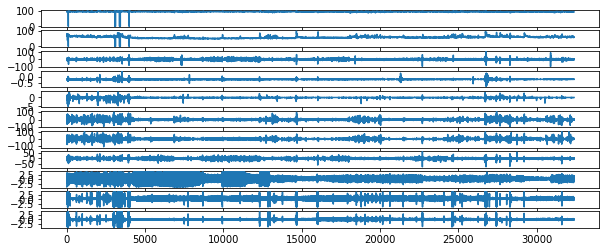

In [8]:
with open(ROOT + "\RECORDS", "r") as f:

    for file in f:
        print(file)
        _full_path = os.path.join(ROOT, file).rstrip()
        print(_full_path)
        record = wfdb.rdrecord(_full_path)
        print(record)
        annotation1 = wfdb.rdann(_full_path, "hypn")
        annotation2 = wfdb.rdann(_full_path, "arou")

        

        print(annotation1.__dict__)

        print("\n", "-"*80, "\n")
        print(annotation2.__dict__)

        print("\n", "-"*80, "\n")
        print(record.__dict__)
        
        wfdb.plot_wfdb(record=record, annotation=annotation1, plot_sym=True,
                   time_units='seconds', title='MIT-BIH Record 100',
                   figsize=(10,4))
        wfdb.plot_wfdb(record=record, annotation=annotation2, plot_sym=True,
           time_units='seconds', title='MIT-BIH Record 100',
           figsize=(10,4))

        print(asdads)